<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Model_WithoutKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf 
import pickle
from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math
from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow
from tensorflow.python.tools import inspect_checkpoint as ckpt 



In [0]:
#FEATURES AND LABELS  
 
with open('/content/labelsFinal_withprevpm.bin','rb') as file:
  labels = pickle.load(file)
  
  
with open('/content/featuresFinal_withprevpm.bin','rb') as file:
  features = pickle.load(file)

In [0]:
x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [29]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8944649073342488413
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2132141567392441753
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3451464735758311551
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14737717720861094155
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [30]:
x = tf.placeholder(shape = (None,10), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

#Layer 1 
w1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((10, 15))), name = 'w1')
b1 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,15))), name = 'b1')

#Layer2 

w2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((15,25))), name = 'w2')
b2 = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,25))), name = 'b2')

#out

wo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((25,1))), name = 'wo')
bo = tf.Variable((tf.glorot_uniform_initializer(dtype = tf.float32)((1,1))), name = 'bo')


W0830 18:06:36.326289 140529463117696 deprecation.py:506] From <ipython-input-30-efd924619411>:5: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0830 18:06:36.327644 140529463117696 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
hidl1 = tf.add(tf.matmul(x,w1),b1, name ='hidden1')
hidl1 = tf.nn.relu(hidl1)
hidl2 = tf.add(tf.matmul(hidl1,w2),b2, name = 'hidden2')
hidl2 = tf.nn.relu(hidl2)
out = tf.add(tf.matmul(hidl2,wo),bo,name = 'output')


In [0]:
## MSE - Loss function
loss = tf.reduce_mean(tf.square(tf.subtract(y,out))) 

## Optimizer - Adam
opt = tf.train.AdamOptimizer(name = 'optimizer', learning_rate=0.005)
op_train = opt.minimize(loss, name ='train_op')


In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

3892.5825	3606.8203
3937.1797	2801.804
4758.3184	3404.2341
1760.5826	2571.785
4339.702	2341.8662
3140.7385	3351.7231
4165.617	4219.202
3786.8208	2059.408
3474.59	3328.5222
4257.3413	4302.3525
2889.4448	2339.223
1512.8444	2921.526
3251.8088	3847.655
2743.2617	1947.0203
3778.5452	2802.8557
2581.946	3689.1245
2855.6985	2092.6843
2237.1753	1809.7891
2407.2073	2613.9172
3224.4854	2817.6865
2619.3022	2065.8975
2258.8564	3133.2542
2294.7778	2859.9595
1236.6482	2811.9922
3407.0088	1753.896
3422.186	2053.775
3593.6543	3414.8647
1326.0089	1448.4539
4329.06	1847.377
1371.1893	3623.708
1678.5789	2503.686
2066.4644	1593.0667
3650.8604	1864.9839
2749.5454	903.12463
2878.691	1784.9923
1944.5419	1771.4565
802.58887	2396.2793
1898.0137	905.5252
1303.48	1473.2671
1396.3348	789.06006
744.10254	1886.0454
1715.1127	645.79114
1732.0886	561.9935
1251.7942	1224.9363
1402.4298	2451.9053
1333.1355	709.97833
416.11246	982.6124
513.76025	1005.09827
443.6197	332.58575
561.60767	1841.7451
492.12695	543.9796
305.264

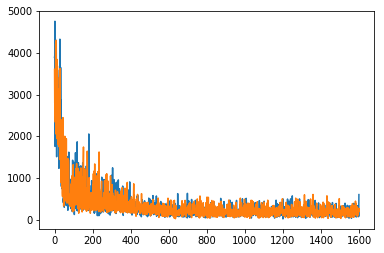

In [35]:

train=[]
val=[]

with tf.device('/device:CPU:0'):
  update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    #saved.restore(sess, "/content/final_check_weights.ckpt")
    mini =[]
    for i in range(1600):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
      
      #TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
      z= sess.run([loss,op_train, update_ops], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      
      ##VALIDATION LOSS
      
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    plt.plot(train)
    plt.plot(val)
    save_path = save.save(sess, "/content/final_TBP.ckpt")
    print('Saved model!')
    
 

In [0]:
val = []

with tf.Session() as sess:
    
    saver = tf.train.Saver()
    saver.restore(sess, "/content/final_TBP.ckpt")
    val.append(sess.run('output',feed_dict={x : x_batch}))

In [41]:
print(val[0])

None


In [0]:
print(type(tf.get_default_graph().as_graph_def()))
tf.io.write_graph(tf.get_default_graph().as_graph_def(), '/content/', 'FINAL_GRAPH.pbtxt')

In [0]:
with open('/content/FINAL_GRAPH.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())
  

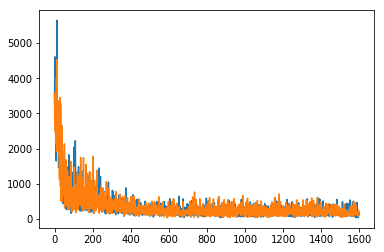

In [0]:
plt.plot(train[1:])
plt.plot(val[1:])

In [0]:
tf.trainable_variables()

[<tf.Variable 'w1:0' shape=(10, 15) dtype=float32_ref>,
 <tf.Variable 'b1:0' shape=(1, 15) dtype=float32_ref>,
 <tf.Variable 'w2:0' shape=(15, 25) dtype=float32_ref>,
 <tf.Variable 'b2:0' shape=(1, 25) dtype=float32_ref>,
 <tf.Variable 'wo:0' shape=(25, 1) dtype=float32_ref>,
 <tf.Variable 'bo:0' shape=(1, 1) dtype=float32_ref>]

Restoration Files (No need to run these unless required for additional analysis)

In [0]:
with open('/content/x_test.bin','wb') as file:
  pickle.dump(x_test_t, file)
with open('/content/y_test.bin','wb') as file:
  pickle.dump(y_test_t, file)